In [ ]:
from google.colab import files
uploaded = files.upload()

In [4]:
import pandas as pd
undebate = pd.read_csv('C:\Users\seema\OneDrive\Desktop\COURSE\360DigiTMG Course\Data Science_03052023_10AM(20032023)\Module 3.g-Natural Language Processing\Topic Modeling-LDA')

In [5]:
undebate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2507 entries, 0 to 2506
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            2507 non-null   int64 
 1   session               2507 non-null   int64 
 2   year                  2507 non-null   int64 
 3   country               2507 non-null   object
 4   text                  2507 non-null   object
 5   paragraphs            2507 non-null   object
 6   number_of_paragraphs  2507 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 137.2+ KB


In [7]:
print(repr(undebate.iloc[666]["text"][0:200])) #repr a printable representation of an object

'\nMay I express my gratitude for the honour of representing\nfor the first time, as Head of State, the independent country\nof Uzbekistan at the United Nations General Assembly.\nWe see the United Nations'


In [8]:
print(repr(undebate.iloc[729]["text"][0:200]))

'\ufeff179.\t It is with great pleasure that I extend to Mr. Lazar Mojsov, the representative of Yugoslavia, my heartfelt congratulations and best wishes on his election as President of this session of the G'


In [9]:
import re
undebate["paragraphs"] = undebate["text"].map(lambda text: re.split('[.?!]\\s*\n', text)) # split at full stops, exclamation points and question marks
undebate["number_of_paragraphs"] = undebate["paragraphs"].map(len)

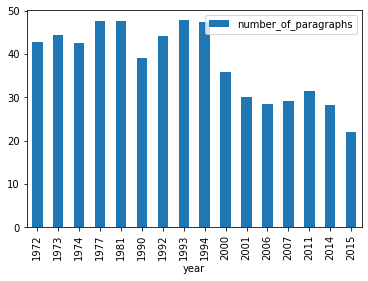

In [10]:
%matplotlib inline
undebate.groupby('year').agg({'number_of_paragraphs': 'mean'}).plot.bar()

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [12]:
tfidf_text = TfidfVectorizer(stop_words = stopwords, min_df = 5, max_df = 0.7)  # min_df means Terms must have DF >= 5 to be considered, max_df # Removes terms with DF higher than the 70% of the documents
vectors_text = tfidf_text.fit_transform(undebate['text'])
vectors_text.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)


(2507, 16798)

In [13]:
# flatten the paragraphs keeping the years
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year } 
                               for paragraphs, year in \
                               zip(undebate["paragraphs"], undebate["year"]) 
                                    for paragraph in paragraphs if paragraph])

In [42]:
tfidf_para_vectorizer = TfidfVectorizer(stop_words = stopwords, min_df = 5, max_df = 0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
tfidf_para_vectors.shape

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  % sorted(inconsistent)


(92741, 17253)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

count_para_vectorizer = CountVectorizer(stop_words = stopwords, min_df = 5, max_df = 0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])

In [16]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state = 42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors) # Documents vs topics
H_lda_para_matrix = lda_para_model.components_   # words vs topics

In [17]:
W_lda_para_matrix

array([[0.00400003, 0.00400002, 0.00400002, ..., 0.00400004, 0.00400008,
        0.00400008],
       [0.14106928, 0.00208414, 0.0020838 , ..., 0.00208368, 0.10540669,
        0.00208395],
       [0.39317799, 0.00238143, 0.00238183, ..., 0.00238185, 0.30600534,
        0.00238165],
       ...,
       [0.00312526, 0.38466046, 0.43089508, ..., 0.00312603, 0.00312527,
        0.00312554],
       [0.00769446, 0.67955949, 0.00769328, ..., 0.00769475, 0.00769468,
        0.25888728],
       [0.00322631, 0.62602042, 0.00322612, ..., 0.00322645, 0.00322628,
        0.00322714]])

In [18]:
H_lda_para_matrix

array([[2.15837800e+01, 1.00008145e-01, 1.00009675e-01, ...,
        2.09977939e+00, 1.00002046e-01, 1.00019159e-01],
       [1.00006784e-01, 1.00004667e-01, 1.00003665e-01, ...,
        1.00013419e-01, 1.00001862e-01, 1.09420370e+01],
       [3.91114854e+02, 1.00006460e-01, 1.00005814e-01, ...,
        1.00000000e-01, 1.00101070e-01, 1.00018234e-01],
       ...,
       [1.09924737e-01, 1.00000714e-01, 1.00001398e-01, ...,
        1.00090502e-01, 1.00005809e-01, 1.00008277e-01],
       [1.36766378e+02, 1.00006273e-01, 1.00004623e-01, ...,
        1.00118915e-01, 1.00004834e-01, 1.00016730e-01],
       [9.63326840e-01, 9.40999567e+01, 8.00999566e+01, ...,
        1.00252013e-01, 1.00007865e-01, 2.19236130e+00]])

In [21]:
def display_topics(model, features, no_top_words = 5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]],
                  word_vector[largest[i]]*100.0/total))


Topic 00
  nuclear (2.33)
  weapons (1.75)
  international (1.37)
  disarmament (1.29)
  states (1.06)

Topic 01
  international (2.07)
  human (2.06)
  rights (1.99)
  peace (1.83)
  world (1.52)

Topic 02
  countries (3.45)
  economic (2.35)
  development (2.33)
  developing (1.64)
  world (1.52)

Topic 03
  peace (1.59)
  east (1.54)
  israel (1.41)
  middle (1.40)
  security (1.37)

Topic 04
  government (2.83)
  people (2.62)
  country (2.38)
  national (1.36)
  democratic (1.16)

Topic 05
  world (1.76)
  africa (1.55)
  people (1.29)
  south (1.01)
  war (0.95)

Topic 06
  general (3.68)
  nations (3.40)
  united (3.26)
  assembly (2.61)
  session (2.22)

Topic 07
  international (2.32)
  countries (1.37)
  nations (1.12)
  problems (1.12)
  world (0.94)

Topic 08
  united (4.62)
  nations (3.77)
  states (1.86)
  council (1.46)
  republic (1.43)

Topic 09
  peace (2.09)
  conflict (1.05)
  united (1.03)
  efforts (1.01)
  international (1.00)


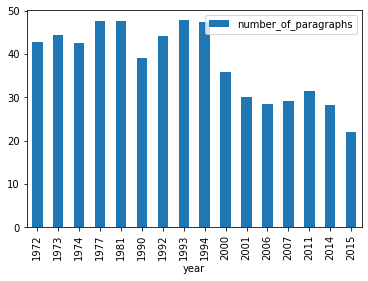

In [23]:
import re
undebate["paragraphs"] = undebate["text"].map(lambda text: re.split('[.?!]\\s*\n', text))
undebate["number_of_paragraphs"] = undebate["paragraphs"].map(len)

undebate.groupby('year').agg({'number_of_paragraphs': 'mean'}).plot.bar()


from sklearn.feature_extraction.text import TfidfVectorizer
#pip install spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

tfidf_text = TfidfVectorizer(stop_words = stopwords, min_df = 5, max_df = 0.7)
vectors_text = tfidf_text.fit_transform(undebate['text'])
vectors_text.shape

# flatten the paragraphs keeping the years
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year } 
                               for paragraphs, year in \
                               zip(undebate["paragraphs"], undebate["year"]) 
                                    for paragraph in paragraphs if paragraph])

tfidf_para_vectorizer = TfidfVectorizer(stop_words = stopwords, min_df = 5,max_df = 0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
tfidf_para_vectors.shape

from sklearn.feature_extraction.text import CountVectorizer

count_para_vectorizer = CountVectorizer(stop_words = stopwords, min_df = 5, max_df = 0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])

from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state = 42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

def display_topics(model, features, no_top_words = 5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]],
                  word_vector[largest[i]]*100.0/total))

display_topics(lda_para_model, tfidf_para_vectorizer.get_feature_names())

In [25]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 8.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=d42e1111ac1a2d9859231ae09fa969e66c788144bf129da36ab332655a04d766
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=587dd7e7d62c59a1af85bd094e70a94726763eb41910ab10bb6bd9b656aa7487
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built pyLDAvis sklearn


In [26]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors,
                            count_para_vectorizer, sort_topics = False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-on

In [27]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [28]:
def wordcloud_topics(model, features, no_top_words = 40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color = "white", max_words = 100,
                       width = 960, height = 540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize = (12, 12))
        plt.imshow(wc, interpolation = 'bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

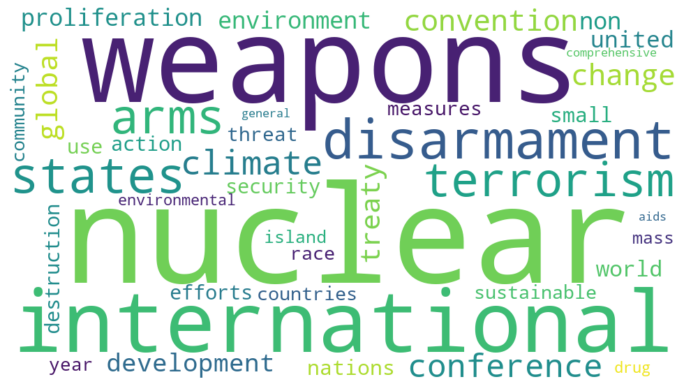

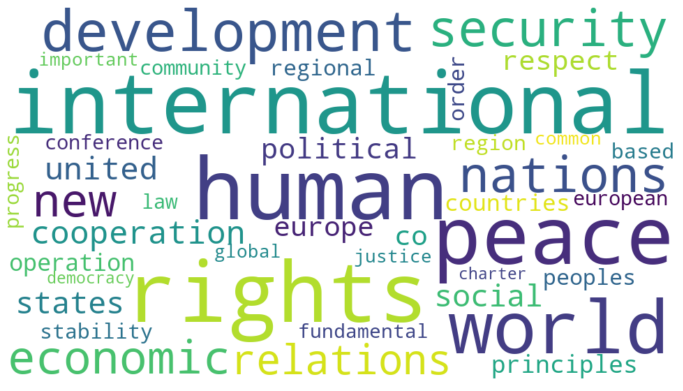

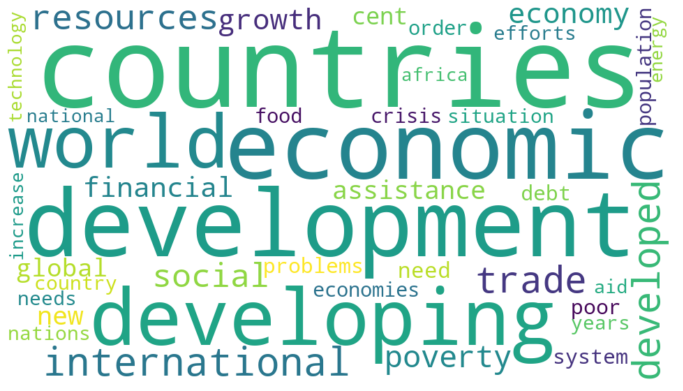

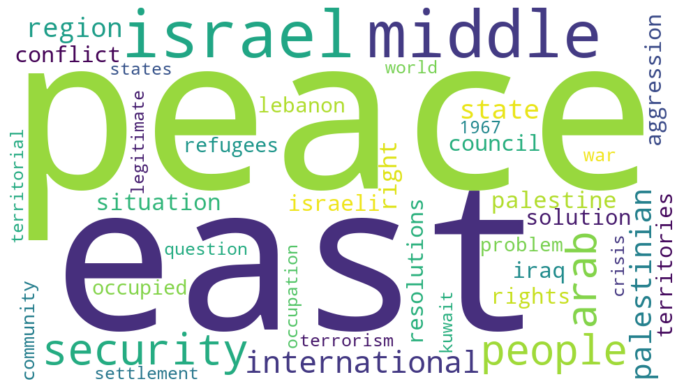

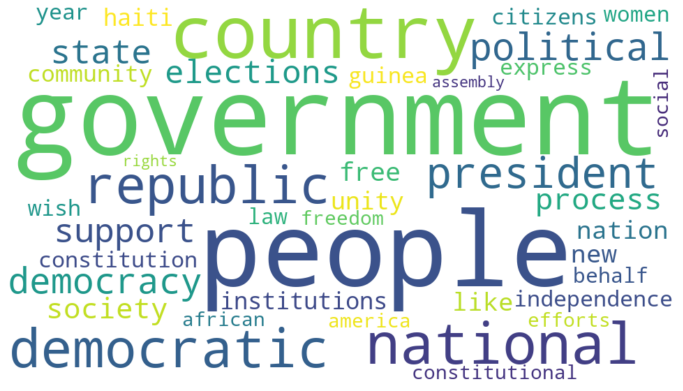

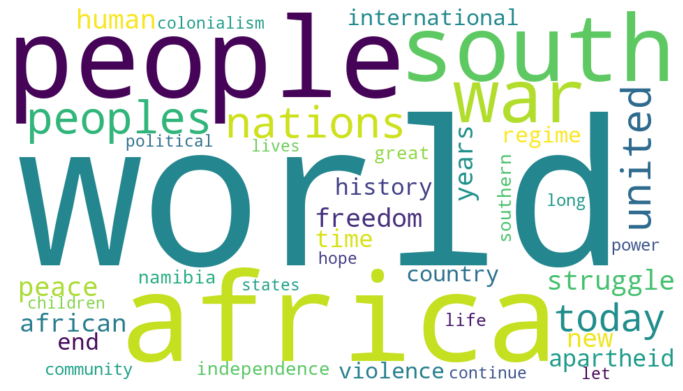

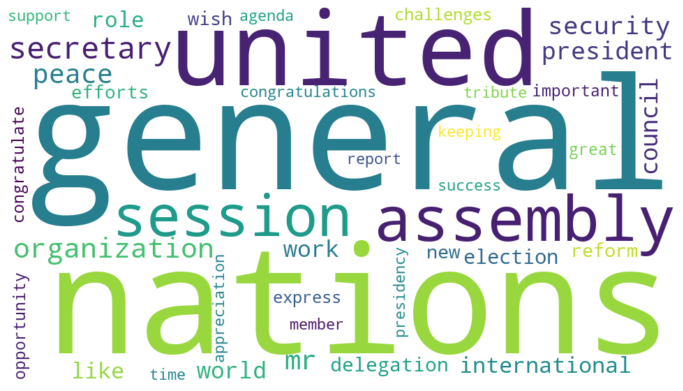

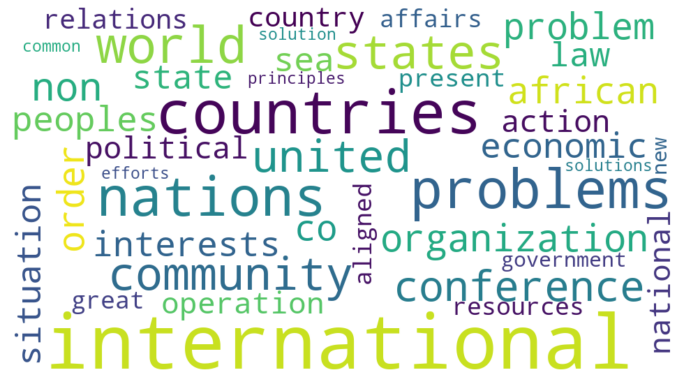

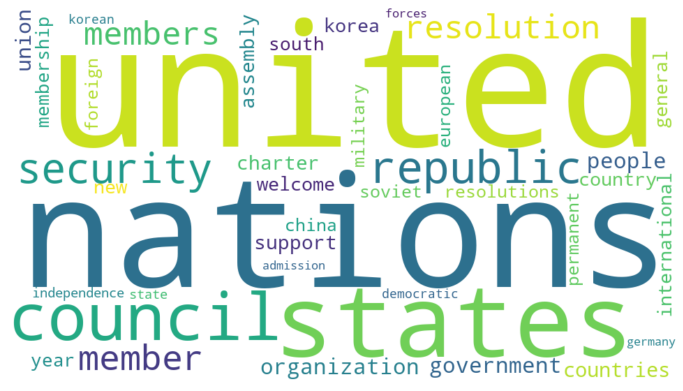

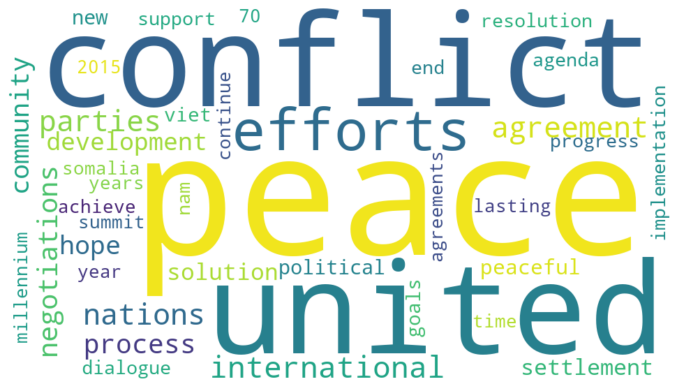

In [29]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names())

In [30]:
# create tokenized documents
gensim_paragraphs = [[w for w in re.findall(r'\b\w\w+\b' , paragraph.lower())
                          if w not in stopwords]
                             for paragraph in paragraph_df["text"]]

In [31]:
from gensim.corpora import Dictionary
dict_gensim_para = Dictionary(gensim_paragraphs)

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [32]:
dict_gensim_para.filter_extremes(no_below = 5, no_above = 0.7)

bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) for paragraph in gensim_paragraphs]

In [33]:
from gensim.models import TfidfModel
tfidf_gensim_para = TfidfModel(bow_gensim_para)
vectors_gensim_para = tfidf_gensim_para[bow_gensim_para]

In [34]:
from gensim.models import LdaModel
lda_gensim_para = LdaModel(corpus = bow_gensim_para, id2word = dict_gensim_para,
    chunksize = 2000, alpha = 'auto', eta = 'auto', iterations = 400, num_topics = 10, 
    passes = 20, eval_every = None, random_state = 42)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [35]:
def display_topics_gensim(model):
    for topic in range(0, model.num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=5):
            print("  %s (%2.2f)" % (word, prob))

In [36]:
display_topics_gensim(lda_gensim_para)


Topic 00
  peace (0.04)
  region (0.02)
  conflict (0.02)
  east (0.02)
  situation (0.02)

Topic 01
  afghanistan (0.06)
  afghan (0.02)
  al (0.02)
  minister (0.02)
  2005 (0.02)

Topic 02
  countries (0.09)
  economic (0.04)
  developing (0.03)
  development (0.03)
  poverty (0.02)

Topic 03
  nations (0.10)
  united (0.10)
  security (0.05)
  states (0.04)
  council (0.03)

Topic 04
  general (0.09)
  assembly (0.06)
  session (0.04)
  secretary (0.04)
  president (0.03)

Topic 05
  people (0.03)
  human (0.03)
  country (0.02)
  government (0.02)
  rights (0.02)

Topic 06
  africa (0.08)
  african (0.06)
  south (0.05)
  independence (0.02)
  continent (0.02)

Topic 07
  international (0.04)
  world (0.02)
  development (0.02)
  community (0.01)
  new (0.01)

Topic 08
  republic (0.02)
  years (0.02)
  war (0.02)
  year (0.01)
  great (0.01)

Topic 09
  terrorism (0.09)
  weapons (0.03)
  nuclear (0.03)
  convention (0.02)
  disarmament (0.02)


In [37]:
from gensim.models.coherencemodel import CoherenceModel

lda_gensim_para_coherence = CoherenceModel(model = lda_gensim_para, texts = gensim_paragraphs, dictionary = dict_gensim_para, coherence = 'c_v')
lda_gensim_para_coherence_score = lda_gensim_para_coherence.get_coherence()
print(lda_gensim_para_coherence_score)

0.5816679820549596


In [38]:
top_topics = lda_gensim_para.top_topics(vectors_gensim_para, topn = 5)
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(top_topics)
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -2.3509.


In [39]:
[(t[1], " ".join([w[1] for w in t[0]])) for t in top_topics]

[(-1.5032594031098014, 'nations united security states council'),
 (-1.5427691142570408, 'general assembly session secretary president'),
 (-1.613336670987519, 'international world development community new'),
 (-1.758293190749167, 'countries economic developing development poverty'),
 (-1.851878859221855, 'people human country government rights'),
 (-2.0540445468539583, 'peace region conflict east situation'),
 (-2.1032774227713227, 'africa african south independence continent'),
 (-2.383861690602953, 'terrorism weapons nuclear convention disarmament'),
 (-2.415188655313667, 'republic years war year great'),
 (-6.282701307466928, 'afghanistan afghan al minister 2005')]

In [40]:
from tqdm import tqdm

In [41]:
from gensim.models.ldamulticore import LdaMulticore
lda_para_model_n = []
for n in tqdm(range(5, 21)):
    lda_model = LdaMulticore(corpus = bow_gensim_para, id2word = dict_gensim_para,
                             chunksize = 2000, eta = 'auto', iterations = 400,
                             num_topics = n, passes = 20, eval_every = None,
                             random_state = 42)
    lda_coherence = CoherenceModel(model = lda_model, texts = gensim_paragraphs,
                                   dictionary = dict_gensim_para, coherence = 'c_v')
    lda_para_model_n.append((n, lda_model, lda_coherence.get_coherence()))

100%|██████████| 16/16 [55:34<00:00, 208.42s/it]


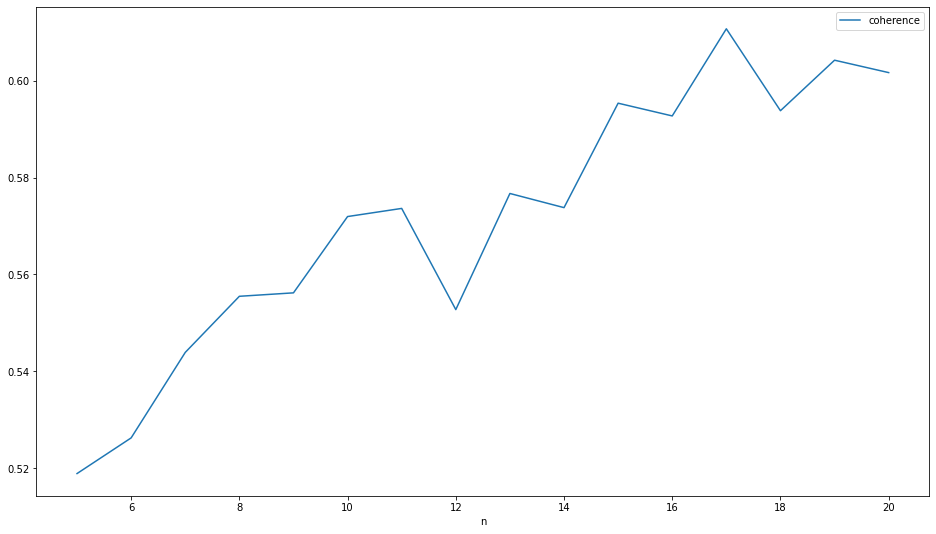

In [43]:
pd.DataFrame(lda_para_model_n, columns = ["n", "model", \
    "coherence"]).set_index("n")[["coherence"]].plot(figsize = (16,9))

In [46]:
display_topics_gensim(lda_para_model_n[12][1])


Topic 00
  peace (0.03)
  international (0.03)
  world (0.02)
  peoples (0.01)
  principles (0.01)

Topic 01
  people (0.02)
  right (0.02)
  israel (0.01)
  state (0.01)
  arab (0.01)

Topic 02
  world (0.04)
  war (0.02)
  today (0.01)
  new (0.01)
  problems (0.01)

Topic 03
  nations (0.09)
  united (0.09)
  organization (0.02)
  peace (0.02)
  international (0.01)

Topic 04
  terrorism (0.03)
  terrorist (0.02)
  people (0.02)
  september (0.02)
  11 (0.02)

Topic 05
  people (0.02)
  government (0.02)
  country (0.02)
  afghanistan (0.01)
  humanitarian (0.01)

Topic 06
  states (0.02)
  european (0.02)
  union (0.02)
  conference (0.02)
  sea (0.02)

Topic 07
  countries (0.05)
  economic (0.03)
  developing (0.02)
  international (0.02)
  development (0.01)

Topic 08
  new (0.02)
  cooperation (0.01)
  democratic (0.01)
  relations (0.01)
  political (0.01)

Topic 09
  terrorism (0.04)
  international (0.03)
  fight (0.01)
  global (0.01)
  community (0.01)

Topic 10
  council